In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
train_df = pd.read_csv(r'C:\Users\Sinam\Desktop\Real or not Kaggle\train.csv')
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv(r'C:\Users\Sinam\Desktop\Real or not Kaggle\test.csv')
test_df.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
sample_submission = pd.read_csv(r'C:\Users\Sinam\Desktop\Real or not Kaggle\sample_submission.csv')
sample_submission.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


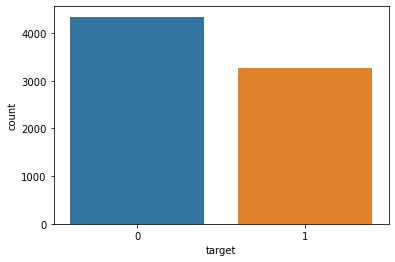

In [6]:
target = train_df['target']
sns.countplot(target)
train_df.drop(['target'], inplace =True,axis =1)

In [8]:
def concat_df(train_df, test_df):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_df, test_df], sort=True).reset_index(drop=True)
df_all = concat_df(train_df, test_df)
print(train_df.shape)
print(test_df.shape)
print(df_all.shape)
df_all.head()

(7613, 4)
(3263, 4)
(10876, 4)


,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [10]:
features = ['keyword','location']
for feat in features : 
    print("The number of missing values in "+ str(feat)+" is "+str(df_all[feat].isnull().sum())+ " for the combined dataset")
    print("The number of missing values in "+ str(feat)+" is "+str(train_df[feat].isnull().sum())+ " for the train dataset")
    print("The number of missing values in "+ str(feat)+" is "+str(test_df[feat].isnull().sum())+ " for the test dataset")

The number of missing values in keyword is 87 for the combined dataset
The number of missing values in keyword is 61 for the train dataset
The number of missing values in keyword is 26 for the test dataset
The number of missing values in location is 3638 for the combined dataset
The number of missing values in location is 2533 for the train dataset
The number of missing values in location is 1105 for the test dataset


In [12]:
# To check if there are any keywords which are missing in the train set but present in the test set
keyw_train = train_df['keyword'].unique()
keyw_test = test_df['keyword'].unique()
print(set(keyw_train)==set(keyw_test))

True


In [46]:
import pip
package_names=['tensorflow', 'keras']
pip.main(['install'] + package_names + ['--upgrade']) 

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=a67f1775a56f28f616dfab17b6c7b73de426ce715b0c2cd4fcb42fd2708a73f7
  Stored in directory: c:\users\sinam\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor


0

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
sentences = train_df['text']
# 80% of total data
train_size = int(7613*0.8)
train_sentences = sentences[:train_size]
train_labels = target[:train_size]

test_sentences = sentences[train_size:]
test_labels = target[train_size:]
# Setting our parameters for the tokenizer (currently using default, we will tune them once we have optimised the rest of the model)
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [50]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 14)                238       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 160,253
Trainable params: 160,253
Non-trainable params: 0
_________________________________________________________________


In [51]:
num_epochs = 10
history = model.fit(padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels))

Epoch 1/10
191/191 [==============================] - 1s 5ms/step - loss: 0.6799 - accuracy: 0.5793 - val_loss: 0.6873 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 1s 3ms/step - loss: 0.6662 - accuracy: 0.5793 - val_loss: 0.6711 - val_accuracy: 0.5345
Epoch 3/10
191/191 [==============================] - 1s 3ms/step - loss: 0.6211 - accuracy: 0.6521 - val_loss: 0.6121 - val_accuracy: 0.7426
Epoch 4/10
191/191 [==============================] - 1s 3ms/step - loss: 0.5508 - accuracy: 0.7658 - val_loss: 0.5604 - val_accuracy: 0.7584
Epoch 5/10
191/191 [==============================] - 1s 4ms/step - loss: 0.4814 - accuracy: 0.8095 - val_loss: 0.5250 - val_accuracy: 0.7590
Epoch 6/10
191/191 [==============================] - 1s 3ms/step - loss: 0.4236 - accuracy: 0.8358 - val_loss: 0.4940 - val_accuracy: 0.7866
Epoch 7/10
191/191 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8581 - val_loss: 0.4766 - val_accuracy: 0.7892
Epoch 

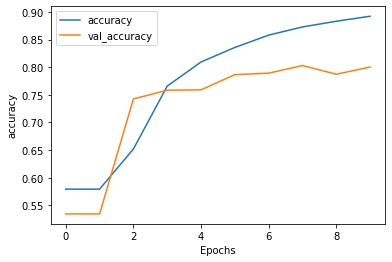

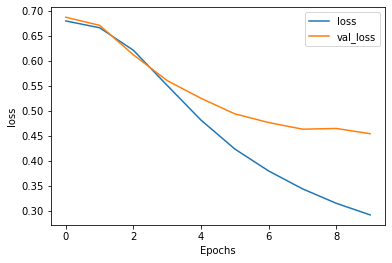

In [53]:
# Analyzing model performance in an accuracy vs epoch graph
import matplotlib.pyplot as plt
def plot(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot(history, "accuracy")
plot(history, 'loss')

In [55]:
tokenizer_1 = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer_1.fit_on_texts(train_df['text'])
word_index = tokenizer_1.word_index
sequences = tokenizer_1.texts_to_sequences(train_df['text'])
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

true_test_sentences = test_df['text']
testing_sequences = tokenizer_1.texts_to_sequences(true_test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_2.summary()
num_epochs = 10
history = model_2.fit(padded, target, epochs=num_epochs, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
238/238 - 1s - loss: 0.6800 - accuracy: 0.5703
Epoch 2/10
238/238 - 1s - loss: 0.6437 - accuracy: 0.6281
Epoch 3/10
238/238 - 1s - loss: 0.5365 - accuracy: 0.7680
Epoch 4/10
238/238 - 1s - loss: 0.4426 - accuracy: 0.8112
Epoch 5/10
238

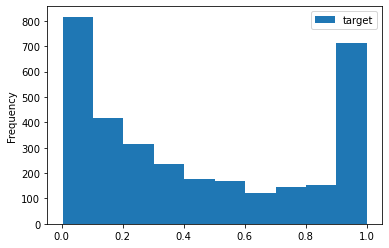

In [56]:
# testing data
output = model_2.predict(testing_padded)
pred_plot =  pd.DataFrame(output, columns=['target'])
pred_plot.plot.hist()

In [57]:
final_output = []
for val in pred_plot.target:
    if val > 0.5:
        final_output.append(1)
    else:
        final_output.append(0)

In [62]:
sample_submission['target'] = final_output
# submission['id'] = test['id']
sample_submission.to_csv("real_or_not_tensorflow_submission.csv", index=False)
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
